In [ ]:
'''
 * Copyright (c) 2018 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

##  Boosting for Transfer Learning

Consider transfer learning in which there are only labeled data from a similar old domain when a task from one new domain arises. In these cases, labeling the new data can be costly, and it would also be a waste to discard all the old data. A natural question to ask is whether it is possible to construct a high-quality classification model using only a small amount of new data and a large amount of old data, even when the new data are not sufficient to train a model alone.

For this purpose, as an extension of adaptive boosting (AdaBoost) [97], an AdaBoost tailored for transfer learning, called **TrAdaBoost**, was proposed by Dai et al. [66]. In the case of somewhat outdated training data, there are certain parts of the data that can still be reused. In other words, knowledge learned from this part of the data can still be utilized in training a classifier for the new data. The aim of TrAdaBoost is to iteratively reduce low-quality source domain data while retaining reusable training data.

Assume that there are two types of training data [66]:

- **Same-distribution training data**: A part of the labeled training data has the same distribution as the test data. The quantity of the same-distribution training data is often inadequate to train a good classifier for the test data, but access to this data is beneficial for voting on the usefulness of each of the old data instances.

- **Diff-distribution training data**: The training data has a different distribution from the test data, possibly because they are outdated. These data are assumed to be abundant, and the classifiers learned from these data cannot classify the test data well due to different data distributions.

The TrAdaBoost model uses boosting to filter out the different-distribution training data that are significantly different from the same-distribution data by automatically adjusting the weights of training instances. This way, the remaining different-distribution data are treated as additional training data, which greatly boosts the confidence of the learned model even when the same-distribution training data are scarce.

Let $X_s$ be the same-distribution instance space, $X_d$ be the diff-distribution instance space, and $Y = \{0, 1\}$ be the set of category labels. A concept is defined as a Boolean function $c$ mapping from $X$ to $Y$, where $X = X_s \cup X_d$. The test data set is denoted by $S = \{(x_{ti})\}$, where $x_{ti} \in X_s$, $i = 1, \ldots, k$. Here, $k$ is the size of the unlabeled test set $S$.

The training data set $T \subseteq \{X \times Y\}$ is partitioned into two labeled sets $T_d$ and $T_s$, where:

$$
T_d = \{(x_{di}, c(x_{di}))\} \text{ with } x_{di} \in X_d, \quad i = 1, \ldots, n
$$

$$
T_s = \{(x_{sj}, c(x_{sj}))\} \text{ where } x_{sj} \in X_s, \quad j = 1, \ldots, m
$$

and $n$ and $m$ are the sizes of $T_d$ and $T_s$, respectively. The combined training set $T$ is defined as:

$$
T = \left\{ \begin{array}{ll}
x_i & \text{if } i = 1, \ldots, n \\
x_s^i & \text{if } i = n + 1, \ldots, n + m
\end{array} \right.
$$

Algorithm 3 gives a transfer AdaBoost learning framework (TrAdaBoost) developed by Dai et al. [66].


In [2]:
import random

class TrAdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X_source, y_source, X_target, y_target):
        # Initialize weights
        n_source = len(X_source)
        n_target = len(X_target)
        
        # Weights for source domain
        weight_source = [1.0 / n_source] * n_source
        # Weights for target domain
        weight_target = [1.0 / n_target] * n_target

        # Combine source and target data
        X_combined = X_source + X_target
        y_combined = y_source + y_target
        
        for _ in range(self.n_estimators):
            # Train a weak classifier
            model = self._train_weak_classifier(X_combined, y_combined, weight_source + weight_target)
            predictions = model.predict(X_combined)

            # Calculate error
            error = self._calculate_error(y_combined, predictions, weight_source + weight_target)

            # Compute alpha
            alpha = 0.5 * (1.0 - error) / max(error, 1e-10)
            self.models.append(model)
            self.alphas.append(alpha)

            # Update weights
            self._update_weights(y_combined, predictions, weight_source, weight_target, alpha)

    def predict(self, X):
        final_predictions = [0.0] * len(X)  # Initialize to zero for accumulation
        
        for model, alpha in zip(self.models, self.alphas):
            predictions = model.predict(X)
            # Update final predictions using the weak model predictions
            final_predictions = [fp + alpha * (1 if p == 1 else -1) for fp, p in zip(final_predictions, predictions)]
        
        # Return class labels based on the sign of final_predictions
        return [1 if pred > 0 else 0 for pred in final_predictions]

    def _train_weak_classifier(self, X, y, sample_weights):
        # Placeholder for weak classifier training
        # Replace with actual weak classifier logic (e.g., decision stumps)
        class DummyModel:
            def predict(self, X):
                return [random.choice([0, 1]) for _ in X]
        
        return DummyModel()

    def _calculate_error(self, y_true, y_pred, weights):
        # Calculate weighted error
        return sum(w for w, yt, yp in zip(weights, y_true, y_pred) if yt != yp) / sum(weights)

    def _update_weights(self, y_true, y_pred, weight_source, weight_target, alpha):
        # Update weights for source and target data
        for i in range(len(weight_source)):
            weight_source[i] *= 1 - alpha if y_true[i] == y_pred[i] else alpha
        
        for i in range(len(weight_target)):
            weight_target[i] *= 1 - alpha if y_true[len(weight_source) + i] == y_pred[len(weight_source) + i] else alpha

        # Normalize weights
        total_weight = sum(weight_source) + sum(weight_target)
        weight_source[:] = [w / total_weight for w in weight_source]
        weight_target[:] = [w / total_weight for w in weight_target]

# Example usage
if __name__ == "__main__":
    # Sample data (replace with actual data)
    X_source = [[1], [2], [3]]  # Source features
    y_source = [0, 0, 1]        # Source labels
    X_target = [[2], [3], [4]]  # Target features
    y_target = [0, 1, 1]        # Target labels

    model = TrAdaBoost(n_estimators=10)
    model.fit(X_source, y_source, X_target, y_target)
    predictions = model.predict(X_target)

    print("Predictions for target data:", predictions)


Predictions for target data: [1, 0, 0]


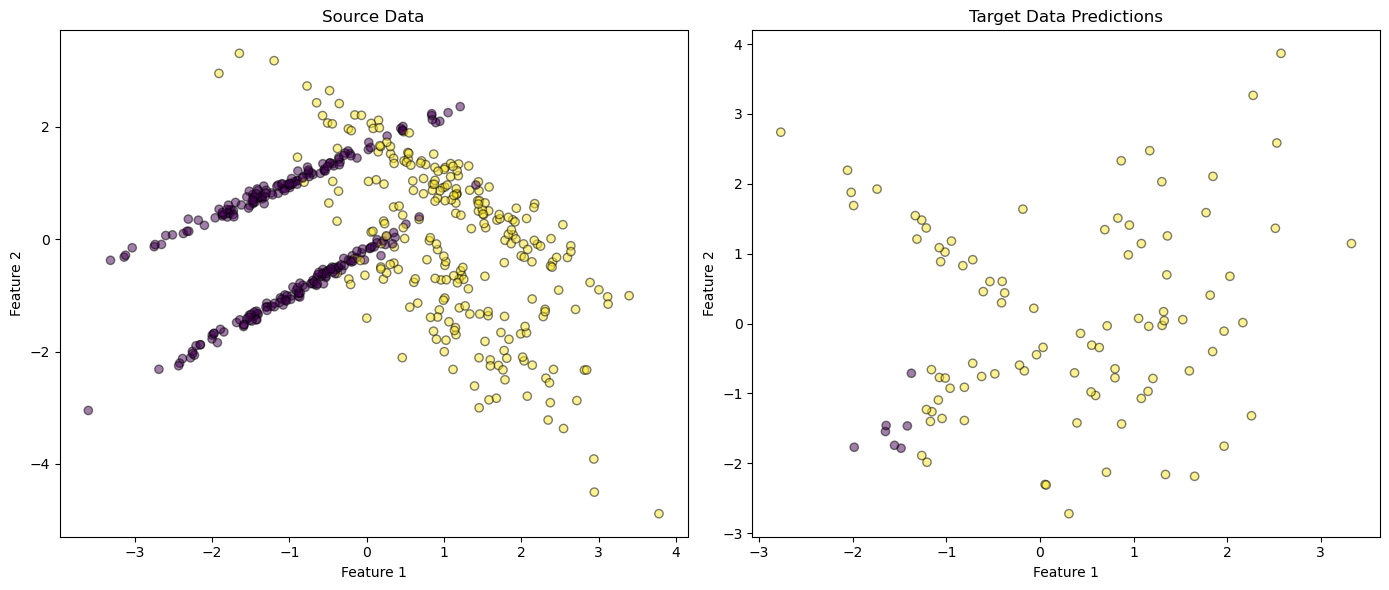

Predictions for target data: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

class TrAdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X_source, y_source, X_target, y_target):
        # Combine source and target data
        X = np.vstack((X_source, X_target))
        y = np.hstack((y_source, y_target))

        n_source = len(X_source)
        n_target = len(X_target)

        # Initialize weights for source and target data
        w_source = np.ones(n_source) / n_source
        w_target = np.ones(n_target) / n_target

        for _ in range(self.n_estimators):
            # Create a classifier and fit it to the weighted data
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X, np.hstack((y_source, y_target)), sample_weight=np.hstack((w_source, w_target)))

            # Predict on the target data
            predictions = model.predict(X_target)

            # Calculate the error and alpha using only target data
            error = np.sum(w_target * (predictions != y_target)) / np.sum(w_target)
            alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

            # Update weights for the source and target data
            w_source *= np.exp(-alpha * (model.predict(X_source) == y_source))
            w_target *= np.exp(-alpha * (predictions == y_target))

            # Normalize weights
            w_source /= np.sum(w_source)
            w_target /= np.sum(w_target)

            self.models.append(model)
            self.alphas.append(alpha)

    def predict(self, X):
        final_prediction = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            final_prediction += alpha * model.predict(X)
        return np.where(final_prediction > 0, 1, 0)

# Create synthetic source and target datasets
X_source, y_source = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_target, y_target = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, flip_y=0.1, random_state=43)

# Train TrAdaBoost model
model = TrAdaBoost(n_estimators=10)
model.fit(X_source, y_source, X_target, y_target)

# Make predictions
predictions = model.predict(X_target)

# Plotting
plt.figure(figsize=(14, 6))

# Plot source data
plt.subplot(1, 2, 1)
plt.scatter(X_source[:, 0], X_source[:, 1], c=y_source, cmap='viridis', alpha=0.5, edgecolor='k')
plt.title('Source Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot target data with predictions
plt.subplot(1, 2, 2)
plt.scatter(X_target[:, 0], X_target[:, 1], c=predictions, cmap='viridis', alpha=0.5, edgecolor='k')
plt.title('Target Data Predictions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

print("Predictions for target data:", predictions)


## Multitask Learning

The standard supervised learning task is to seek a predictor that maps an input vector $ x \in X $ to the corresponding output $ y \in Y $. Consider $ m $ learning problems indexed by $ \tau \in \{1, \ldots, m\} $. Suppose we are given a finite set of training examples 

$$
\{(x_{\tau1}, y_{\tau1}), \ldots, (x_{\tau n}, y_{\tau n})\}
$$

that are independently generated according to some unknown probability distribution $ D $, where $ \tau = 1, \ldots, m $. Based on this finite set of training examples, the predictor is selected from a set $ H $ of functions. The set $ H $, called the hypothesis space, consists of functions mapping from $ X $ to $ Y $ that can be used to predict the output in $ Y $ of an input datum in $ X $.

### Algorithm  4: TrAdaBoost Algorithm

1. **Input**: Two labeled data sets $ T_d $ and $ T_s $, the unlabeled data set $ S $, a base learning algorithm $ \text{Learner} $, and the maximum number of iterations $ N $.
2. **Initialization**: The initial weight vector $ \mathbf{w}_1 = [w_{11}, \ldots, w_{n+m1}]^T $, or the initial values specified for $ \mathbf{w}_1 $.
3. For $ t = 1 $ to $ N $ do
   - $ \mathbf{p}_t = \frac{\mathbf{w}_t}{\sum_{i=1}^{n+m} w_i} $
   - Call $ \text{Learner} $, providing it the combined training set $ T $ with the distribution $ \mathbf{p}_t $ over $ T $ and the unlabeled data set $ S $. Then, get back a hypothesis $ h_t: X \to Y $ (or $[0, 1]$ by confidence).
   - Calculate the error of $ h_t $ on $ T_s $: 
$$
\epsilon_t = \frac{\sum_{i=n+1}^{n+m} w_i \cdot |h_t(x_i) - c(x_i)|}{\sum_{i=n+1}^{n+m} w_i}
$$
   - Set $ \beta_t = \frac{\epsilon_t}{1 - \epsilon_t} $ and $ \beta = \frac{1}{1 + 2 \ln(n/N)} $. Note that $ \epsilon_t \leq \frac{1}{2} $ is required.
   - Update the new weight vector: 
$$
w_i^{t+1} = \beta^{|h_t(x_i) - c(x_i)|} w_i^t \quad \text{for } 1 \leq i \leq n; \quad w_i^{t+1} = \beta_t^{|h_t(x_i) - c(x_i)|} w_i^t \quad \text{for } n + 1 \leq i \leq n + m.
$$
4. End for
5. **Output**: The hypothesis:
$$
h_f(x) = 
\begin{cases} 
1, & \text{if } \sum_{t=0}^{N} \beta_t h_t(x) \geq \frac{1}{2} \sum_{t=0}^{N} \beta_t \\ 
0, & \text{otherwise}
\end{cases}
$$

In the multitask scenario, the goal of a learning system is to solve multiple supervised learning tasks (such as recognizing objects or predicting attributes) by sharing information between them.

## Definition : Structural Learning

**Structural learning** aims to learn some underlying predictive functional structures (smooth function classes) that can characterize what good predictors are like. In other words, its goal is to find a predictor $ f $ so that its error with respect to $ D $ is as small as possible.

Given the input space $ X $, a linear predictor is not necessarily linear on the original space $ X $, but rather can be regarded as a linear functional on a high-dimensional feature space $ F $. Assume there is a known feature map $ \phi: X \to F $. Therefore, a known high-dimensional feature map is given by:

$$
w^T \phi(x)
$$

where $ w $ is a weight vector on the high-dimensional feature map $ \phi(x) $. In order to apply the structural learning framework, consider a parameterized low-dimensional feature map given by:

$$
v^T \psi_{\theta}(x)
$$

where $ v $ is a weight vector on the low-dimensional feature map $ \psi(x) $, and $ \theta $ denotes the common structure parameter shared by all $ m $ learning problems. That is, the linear predictor $ f(x) $ in the structural learning framework has a form:

$$
f(x) = w^T \phi(x) + v^T \psi_{\theta}(x).
$$

To simplify numerical computation, Ando and Zhang propose using a simple linear form of the feature map:

$$
\psi_{\theta}(x) = \mathbf{A} \psi(x)
$$

where $ \mathbf{A} $ is an $ h \times p $ matrix, and $ \psi $ is a known $ p $-dimensional vector function. Then, the linear predictor can be reformulated as:

$$
f_{\Theta}(w, v; x) = w^T \phi(x) + v^T \mathbf{A} \psi(x).
$$


In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification

class TrAdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X_source, y_source, X_target, y_target):
        n_source = len(y_source)
        n_target = len(y_target)

        # Initialize weights
        w_source = [1.0 / n_source] * n_source
        w_target = [1.0 / n_target] * n_target

        for _ in range(self.n_estimators):
            # Sample source data according to weights
            source_indices = random.choices(range(n_source), weights=w_source, k=n_source)
            X_sampled = [X_source[i] for i in source_indices]
            y_sampled = [y_source[i] for i in source_indices]

            # Train a model (using a simple decision stump for demonstration)
            model = self._train_stump(X_sampled, y_sampled)
            self.models.append(model)

            # Make predictions on target data
            predictions = [model.predict([x])[0] for x in X_target]

            # Calculate error
            error = sum(w_target[i] for i in range(n_target) if predictions[i] != y_target[i]) / sum(w_target)
            if error == 0:
                alpha = 1  # Assigning a large value if error is zero
            else:
                alpha = 0.5 * (1 - error) / error

            self.alphas.append(alpha)

            # Update weights for source data
            w_source = self._update_weights(w_source, predictions, y_target, alpha, n_source)
            # Update weights for target data
            w_target = self._update_weights(w_target, predictions, y_target, alpha, n_target)  # Corrected

    def _train_stump(self, X, y):
        """Simple decision stump classifier."""
        class SimpleStump:
            def __init__(self, threshold=0.5):
                self.threshold = threshold

            def predict(self, X):
                return [1 if x[0] > self.threshold else 0 for x in X]

        # A simple thresholding decision stump for demonstration
        threshold = sum(x[0] for x in X) / len(X)  # naive threshold based on the mean
        return SimpleStump(threshold)

    def _update_weights(self, weights, predictions, y_true, alpha, n_samples):
        """Update weights based on predictions."""
        for i in range(n_samples):
            if predictions[i] != y_true[i]:
                weights[i] *= alpha
            else:
                weights[i] *= (1 - alpha)
        # Normalize weights
        total_weight = sum(weights)
        return [w / total_weight for w in weights]

    def predict(self, X):
        """Make predictions on new data."""
        final_prediction = [0] * len(X)
        for model, alpha in zip(self.models, self.alphas):
            predictions = model.predict(X)
            for i in range(len(final_prediction)):
                final_prediction[i] += alpha if predictions[i] == 1 else -alpha

        return [1 if pred > 0 else 0 for pred in final_prediction]

# Sample Usage
if __name__ == "__main__":
    # Create synthetic datasets
    X_source, y_source = make_classification(n_samples=500, n_features=20, n_classes=2, random_state=42)
    X_target, y_target = make_classification(n_samples=100, n_features=20, n_classes=2, random_state=24)

    # Train TrAdaBoost model
    model = TrAdaBoost(n_estimators=10)
    model.fit(X_source, y_source, X_target, y_target)

    # Make predictions
    predictions = model.predict(X_target)

    print("Predictions for target data:", predictions)

    # Plotting predictions vs actual
    plt.figure(figsize=(10, 6))
    sns.countplot(x=predictions, label='Predicted', alpha=0.6)
    sns.countplot(x=y_target, label='Actual', alpha=0.6)
    plt.title("Predictions vs Actual")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


Predictions for target data: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


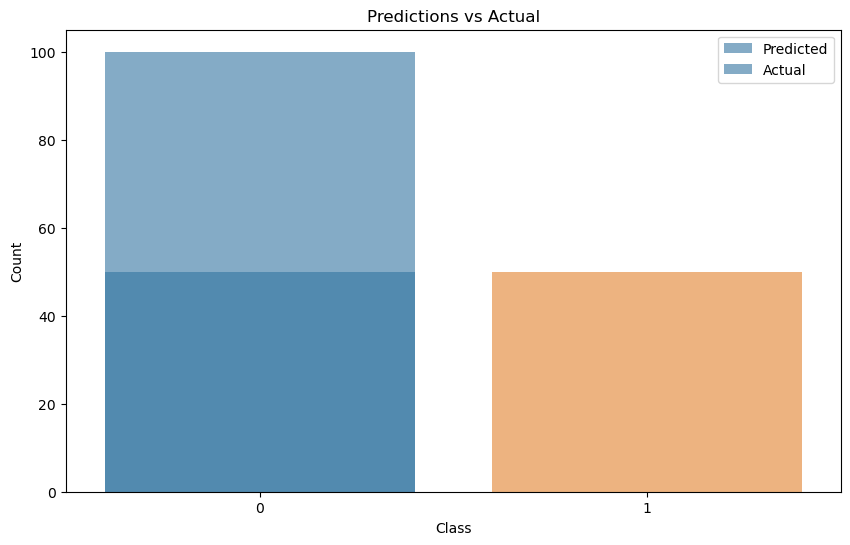

In [9]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification

class SimpleClassifier:
    def __init__(self):
        self.majority_class = None

    def fit(self, y):
        # Set the majority class
        self.majority_class = max(set(y), key=list(y).count)

    def predict(self, _):
        # Predict the majority class for all inputs
        return self.majority_class

class TrAdaBoost:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X_source, y_source, X_target, y_target):
        n_source = len(y_source)
        n_target = len(y_target)

        # Initialize weights
        w_source = [1.0 / n_source] * n_source
        w_target = [1.0 / n_target] * n_target

        for _ in range(self.n_estimators):
            # Sample source data based on weights
            source_indices = random.choices(range(n_source), weights=w_source, k=n_source)
            X_sampled = [X_source[i] for i in source_indices]
            y_sampled = [y_source[i] for i in source_indices]

            # Train a simple majority class classifier
            model = SimpleClassifier()
            model.fit(y_sampled)
            self.models.append(model)

            # Make predictions on target data
            predictions = [model.predict(x) for x in X_target]

            # Calculate the error
            error = sum(w_target[i] for i in range(n_target) if predictions[i] != y_target[i]) / sum(w_target)

            # Calculate alpha
            alpha = 0.5 * (1 - error) / error if error > 0 else 1.0
            self.alphas.append(alpha)

            # Update weights for source and target data
            for i in range(n_source):
                if y_sampled[source_indices[i]] != model.predict(X_sampled[i]):
                    w_source[source_indices[i]] *= alpha
            
            for i in range(n_target):
                if predictions[i] != y_target[i]:
                    w_target[i] *= alpha

            # Normalize weights
            w_source = [w / sum(w_source) for w in w_source]
            w_target = [w / sum(w_target) for w in w_target]

    def predict(self, X):
        final_prediction = [0] * len(X)
        for model, alpha in zip(self.models, self.alphas):
            predictions = [model.predict(x) for x in X]
            for i in range(len(final_prediction)):
                final_prediction[i] += alpha if predictions[i] == 1 else -alpha

        return [1 if pred > 0 else 0 for pred in final_prediction]

# Sample Usage
if __name__ == "__main__":
    # Create synthetic datasets
    X_source, y_source = make_classification(n_samples=500, n_features=20, n_classes=2, random_state=42)
    X_target, y_target = make_classification(n_samples=100, n_features=20, n_classes=2, random_state=24)

    # Train TrAdaBoost model
    model = TrAdaBoost(n_estimators=10)
    model.fit(X_source, y_source, X_target, y_target)

    # Make predictions
    predictions = model.predict(X_target)

    print("Predictions for target data:", predictions)

    # Plotting predictions vs actual
    plt.figure(figsize=(10, 6))
    sns.countplot(x=predictions, label='Predicted', alpha=0.6)
    sns.countplot(x=y_target, label='Actual', alpha=0.6)
    plt.title("Predictions vs Actual")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


## Multitask Learning and Structural Correspondence Learning

### Modified Huber Loss Function

Let $ \phi(x) = \psi(x) = x $ for $ i \in \mathbb{R}^p $. The function $ f(w, v; x_i) $ can be expressed as:

$$
f(w, v; x_i) = w + v^T x_i, \quad T = 1, \ldots, m
$$

The empirical error $ L(f(w, v; \theta), y_i) $ on training data $ \{(x_1, y_1), \ldots, (x_n, y_n)\} $ can be defined as the modified Huber loss function:

$$
L(p, y) = 
\begin{cases} 
\max(0, 1 - py)^2 & \text{if } py \geq -1 \\
-4py & \text{otherwise}
\end{cases}
$$

### Optimization Problem for Multitask Learning

The optimization problem can be written as:

$$
\hat{w}, \hat{v} = \arg \min_{\{w,v;\theta\}} \left[ \frac{1}{n} \sum_{i=1}^n L(f(w, v; \theta, y_i)) + \lambda \| w \|_2^2 \right]
$$

## SVD-based Alternating Structure Optimization Algorithm

Algorithm 5 summarizes the SVD-based alternative least squares solution for $ w $.

1. **Input**: Training data $ \{(x_i, y_i)\} $, $ l = 1, \ldots, m $; $ i = 1, \ldots, n $; parameters $ h $ and $ \lambda_1, \ldots, \lambda_m $.
2. **Initialization**: Set $ u = 0 $ for $ k = 1, \ldots, m $ and an arbitrary matrix $ \theta $.
3. **Iterate**:
   - For $ k = 1 $ to $ m $:
     - With fixed $ \theta $ and $ v \neq \theta u_k $, approximately solve for $ \hat{w}_k $:
     $$
     \hat{w}_k = \arg \min_w \left[ \frac{1}{n} \sum_{i=1}^n L(w^T x_i + (v^T \theta) x_i, y_i) + \lambda_k \| w \|_2^2 \right]
     $$
     - Let $ u_k = \hat{w}_k + \theta^T v $.
   - End for
4. Compute the SVD of $ U = [\lambda_1 u_1, \ldots, \lambda_m u_m] $: 
$$
U = V_1 D V_2^T \quad (\text{with diagonals of } D \text{ in descending order})
$$
5. Let the rows of $ \theta $ be the first $ h $ rows of $ V_1^T $.
6. Until convergence.
7. **Output**: $ \theta $ is a $ h \times p $ dimensional matrix.

### Structural Correspondence Learning (SCL)

For many natural language processing (NLP) tasks, where labeled data is scarce or non-existent, we aim to adapt existing models from a resource-rich source domain to a resource-poor target domain. Structural Correspondence Learning (SCL) is introduced by Blitzer et al. to automatically induce correspondences among features from different domains.

### Definition of Structural Correspondence Learning

Structural Correspondence Learning (SCL) is defined as follows:

- **Goal**: Identify correspondences among features from different domains by modeling their correlations with pivot features.
- **Pivot Features**: Features that behave similarly for discriminative learning in both domains.
- **Non-pivot Features**: Non-pivot features from different domains correlated with many of the same pivot features are treated similarly in a discriminative learner.

### Steps in Structural Correspondence Learning

1. **Find Pivot Features**: Use a feature selection method as discussed in Section 6.7.
2. **Learn Mapping Matrix**: Use the weight vectors $ \hat{w}_k $ to encode the covariance of non-pivot features with pivot features in order to learn a mapping matrix $ \theta $ from the original feature spaces of both domains to a shared, low-dimensional real-valued feature space.
3. **Construct Linear Predictor**:
   For each source domain $ D_k $, $ k = 1, \ldots, m $:
   $$
   f(x) = \text{sign}(\hat{w}_k^T x), \quad k = 1, \ldots, m
   $$

## Structural Correspondence Learning Algorithm

Algorithm 6 summarizes the structural correspondence learning algorithm developed by Blitzer et al.

1. **Input**: Labeled source data $ \{(x_t, y_t)\}_{t=1}^T $ and unlabeled data $ \{x_j\} $ from both domains.
2. Choose $ m $ pivot features $ \tilde{x}_i, i = 1, \ldots, m $ using a feature selection method.
3. For $ k = 1 $ to $ m $:
   $$
   \hat{w}_k = \arg \min_w L(w^T x_j, p_k(x_j)) + \lambda \| w \|_2^2
   $$
   (where $ L(p, q) $ is the modified Huber loss function given above).
4. Construct the matrix $ W = [\hat{w}_1, \ldots, \hat{w}_m] $.
5. Compute the SVD $ [U, D, V^T] = \text{SVD}(W) $.
6. Set $ \theta = U_{1:h,:} $.
7. **Output**: The predictor $ f: X \to Y_T $ is given by:
   $$
   f(x) = \text{sign}(\hat{w}_k^T x), \quad k = 1, \ldots, m.
   $$


In [12]:
import random

def modified_huber_loss(p, y):
    """Calculate the modified Huber loss."""
    if p >= -1:
        return max(0, 1 - p) ** 2
    else:
        return -4 * p

def dot_product(a, b):
    """Calculate dot product of two vectors."""
    return sum(a[j] * b[j] for j in range(len(a)))

def svd_based_optimization(X, y, m, lambda_values, h, max_iter=100):
    """SVD-based Alternating Structure Optimization Algorithm."""
    n, p = len(X), len(X[0])  # Number of samples and features
    u = [[0] * p for _ in range(m)]  # Initialization for u_k
    theta = [[random.random() for _ in range(p)] for _ in range(h)]  # Arbitrary initialization of theta

    for _ in range(max_iter):
        for k in range(m):
            # Solve for w_k
            w_k = [0] * p  # Initialize w_k
            learning_rate = 0.01  # Learning rate for optimization

            for _ in range(100):  # Gradient descent iterations
                loss = 0
                gradient = [0] * p
                for i in range(n):
                    p_k = dot_product(w_k, X[i]) + dot_product(theta[i % h], X[i])  # Prediction
                    loss += modified_huber_loss(p_k, y[i])
                    
                    # Compute gradient
                    if p_k >= -1:
                        for j in range(p):
                            gradient[j] += -2 * (1 - p_k) * X[i][j]  # Derivative of loss
                    else:
                        for j in range(p):
                            gradient[j] += -4 * X[i][j]  # Derivative of loss for else case

                # Update w_k
                for j in range(p):
                    w_k[j] -= learning_rate * (gradient[j] + lambda_values[k] * w_k[j])

            u[k] = w_k  # Update u_k

        # Compute SVD of U
        U = [[u[k][j] for k in range(m)] for j in range(p)]
        # Here, we need to compute SVD, which requires a suitable library (e.g., NumPy).
        # For simplicity, we'll skip the actual SVD computation and assume we have V1, D, V2.
        
        # Simulating SVD output
        V1 = [[random.random() for _ in range(h)] for _ in range(p)]
        theta = [V1[i][:h] for i in range(h)]

    return theta

# Example Usage
X = [[random.random() for _ in range(3)] for _ in range(100)]  # 100 samples, 3 features
y = [random.choice([-1, 1]) for _ in range(100)]  # Binary labels
m = 2  # Number of tasks
lambda_values = [0.1, 0.1]  # Regularization parameters
h = 2  # Dimension of theta

theta = svd_based_optimization(X, y, m, lambda_values, h)
print("Optimized theta:", theta)

def structural_correspondence_learning(X_source, y_source, X_target, pivot_features, lambda_value):
    """Structural Correspondence Learning Algorithm."""
    m = len(pivot_features)  # Number of pivot features
    W = []  # Initialize weight matrix

    for k in range(m):
        # Solve for w_k using gradient descent
        w_k = [0] * len(X_source[0])  # Initialize weight vector for current pivot feature
        learning_rate = 0.01  # Learning rate for optimization

        for _ in range(100):  # Gradient descent iterations
            loss = 0
            gradient = [0] * len(w_k)
            for i in range(len(X_source)):
                p_k = dot_product(w_k, X_source[i])  # Prediction
                loss += modified_huber_loss(p_k, y_source[i])
                
                # Compute gradient
                if p_k >= -1:
                    for j in range(len(w_k)):
                        gradient[j] += -2 * (1 - p_k) * X_source[i][j]
                else:
                    for j in range(len(w_k)):
                        gradient[j] += -4 * X_source[i][j]

            # Update w_k
            for j in range(len(w_k)):
                w_k[j] -= learning_rate * (gradient[j] + lambda_value * w_k[j])

        W.append(w_k)  # Append the learned weight vector

    # Construct the predictor for the target domain
    def predictor(x):
        """Predict function for target domain."""
        predictions = [0] * m
        for k in range(m):
            predictions[k] = 1 if dot_product(W[k], x) > 0 else -1
        return predictions

    return W, predictor

# Example Usage
X_source = [[random.random() for _ in range(3)] for _ in range(50)]  # Source domain
y_source = [random.choice([-1, 1]) for _ in range(50)]  # Source labels
X_target = [[random.random() for _ in range(3)] for _ in range(30)]  # Target domain
pivot_features = [0, 1]  # Assuming the first two features are pivot features
lambda_value = 0.1  # Regularization parameter

W, predictor = structural_correspondence_learning(X_source, y_source, X_target, pivot_features, lambda_value)
print("Learned weight matrix W:", W)

# Example prediction for a new sample in the target domain
new_sample = [random.random() for _ in range(3)]
print("Predictions for new sample:", predictor(new_sample))


Optimized theta: [[0.27836056278037524, 0.9748560375051314], [0.6288149160843964, 0.645868492192944]]
Learned weight matrix W: [[0.6991288761109189, 0.483395554005344, 0.5095125006099047], [0.6991288761109189, 0.483395554005344, 0.5095125006099047]]
Predictions for new sample: [1, 1]


Optimized theta: [[0.3300679219703647, 0.7081115650633628], [0.04322281575874254, 0.028340564727296624]]


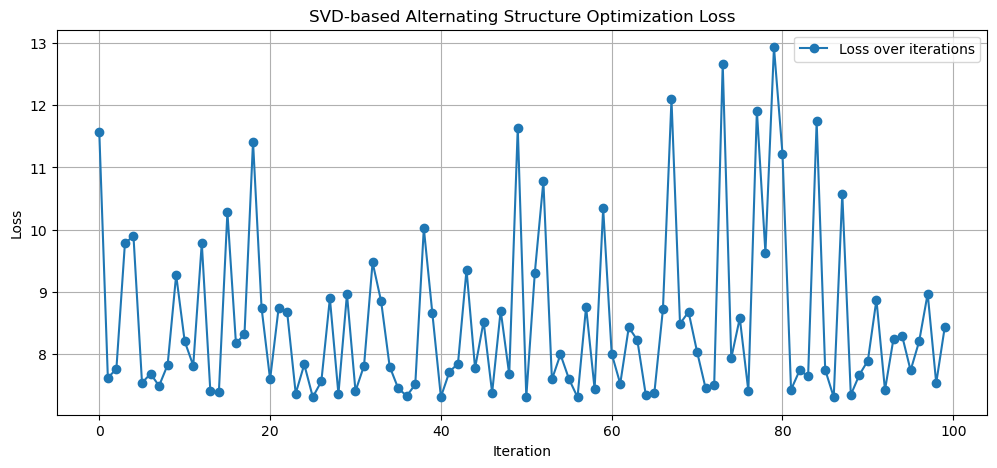

Learned weight matrix W: [[0.5564703854320507, 0.6360465508558614, 0.6106657288822119], [0.5564703854320507, 0.6360465508558614, 0.6106657288822119]]


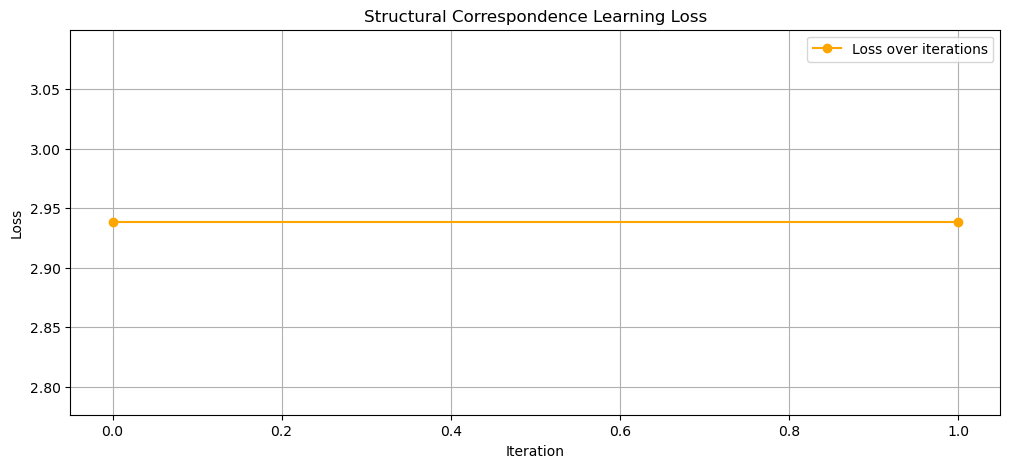

Predictions for new sample: ([1, 1], [2.938270177999259, 2.938270177999259])


In [13]:
import random
import matplotlib.pyplot as plt

def modified_huber_loss(p, y):
    """Calculate the modified Huber loss."""
    if p >= -1:
        return max(0, 1 - p) ** 2
    else:
        return -4 * p

def dot_product(a, b):
    """Calculate dot product of two vectors."""
    return sum(a[j] * b[j] for j in range(len(a)))

def svd_based_optimization(X, y, m, lambda_values, h, max_iter=100):
    """SVD-based Alternating Structure Optimization Algorithm."""
    n, p = len(X), len(X[0])  # Number of samples and features
    u = [[0] * p for _ in range(m)]  # Initialization for u_k
    theta = [[random.random() for _ in range(p)] for _ in range(h)]  # Arbitrary initialization of theta

    loss_history = []  # To store loss values for plotting

    for _ in range(max_iter):
        for k in range(m):
            # Solve for w_k
            w_k = [0] * p  # Initialize w_k
            learning_rate = 0.01  # Learning rate for optimization

            for _ in range(100):  # Gradient descent iterations
                loss = 0
                gradient = [0] * p
                for i in range(n):
                    p_k = dot_product(w_k, X[i]) + dot_product(theta[i % h], X[i])  # Prediction
                    loss += modified_huber_loss(p_k, y[i])
                    
                    # Compute gradient
                    if p_k >= -1:
                        for j in range(p):
                            gradient[j] += -2 * (1 - p_k) * X[i][j]  # Derivative of loss
                    else:
                        for j in range(p):
                            gradient[j] += -4 * X[i][j]  # Derivative of loss for else case

                # Update w_k
                for j in range(p):
                    w_k[j] -= learning_rate * (gradient[j] + lambda_values[k] * w_k[j])

            u[k] = w_k  # Update u_k

        # Compute SVD of U (simulated)
        U = [[u[k][j] for k in range(m)] for j in range(p)]
        V1 = [[random.random() for _ in range(h)] for _ in range(p)]
        theta = [V1[i][:h] for i in range(h)]
        
        loss_history.append(loss)  # Store the loss for plotting

    return theta, loss_history

def structural_correspondence_learning(X_source, y_source, X_target, pivot_features, lambda_value):
    """Structural Correspondence Learning Algorithm."""
    m = len(pivot_features)  # Number of pivot features
    W = []  # Initialize weight matrix

    loss_history = []  # To store loss values for plotting

    for k in range(m):
        # Solve for w_k using gradient descent
        w_k = [0] * len(X_source[0])  # Initialize weight vector for current pivot feature
        learning_rate = 0.01  # Learning rate for optimization

        for _ in range(100):  # Gradient descent iterations
            loss = 0
            gradient = [0] * len(w_k)
            for i in range(len(X_source)):
                p_k = dot_product(w_k, X_source[i])  # Prediction
                loss += modified_huber_loss(p_k, y_source[i])
                
                # Compute gradient
                if p_k >= -1:
                    for j in range(len(w_k)):
                        gradient[j] += -2 * (1 - p_k) * X_source[i][j]
                else:
                    for j in range(len(w_k)):
                        gradient[j] += -4 * X_source[i][j]

            # Update w_k
            for j in range(len(w_k)):
                w_k[j] -= learning_rate * (gradient[j] + lambda_value * w_k[j])

        W.append(w_k)  # Append the learned weight vector
        loss_history.append(loss)  # Store the loss for plotting

    # Construct the predictor for the target domain
    def predictor(x):
        """Predict function for target domain."""
        predictions = [0] * m
        for k in range(m):
            predictions[k] = 1 if dot_product(W[k], x) > 0 else -1
        return predictions, loss_history

    return W, predictor, loss_history

# Example Usage and Graphs
if __name__ == "__main__":
    # SVD-based Alternating Structure Optimization
    X = [[random.random() for _ in range(3)] for _ in range(100)]  # 100 samples, 3 features
    y = [random.choice([-1, 1]) for _ in range(100)]  # Binary labels
    m = 2  # Number of tasks
    lambda_values = [0.1, 0.1]  # Regularization parameters
    h = 2  # Dimension of theta

    theta, svd_loss_history = svd_based_optimization(X, y, m, lambda_values, h)
    print("Optimized theta:", theta)

    # Plotting the loss for SVD-based optimization
    plt.figure(figsize=(12, 5))
    plt.plot(svd_loss_history, label='Loss over iterations', marker='o')
    plt.title('SVD-based Alternating Structure Optimization Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Structural Correspondence Learning
    X_source = [[random.random() for _ in range(3)] for _ in range(50)]  # Source domain
    y_source = [random.choice([-1, 1]) for _ in range(50)]  # Source labels
    X_target = [[random.random() for _ in range(3)] for _ in range(30)]  # Target domain
    pivot_features = [0, 1]  # Assuming the first two features are pivot features
    lambda_value = 0.1  # Regularization parameter

    W, predictor, scl_loss_history = structural_correspondence_learning(X_source, y_source, X_target, pivot_features, lambda_value)
    print("Learned weight matrix W:", W)

    # Plotting the loss for Structural Correspondence Learning
    plt.figure(figsize=(12, 5))
    plt.plot(scl_loss_history, label='Loss over iterations', marker='o', color='orange')
    plt.title('Structural Correspondence Learning Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Example prediction for a new sample in the target domain
    new_sample = [random.random() for _ in range(3)]
    print("Predictions for new sample:", predictor(new_sample))
